# Data Loading

## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Pre Processing

## Importing Necessary Libraries

In [2]:
import os
from PIL import Image
import cv2
from tqdm import tqdm

## Reshaping Image Dimension (64 x 64)

In [3]:
src_base = '/content/drive/MyDrive/animals' # image folder
dst_base = '/content/drive/MyDrive/pre_processed_animals' # pre processed image folder
img_size = 64 # 64 x 64 selected as image dimension

categories = ['cats', 'dogs', 'panda'] # Animal categories

In [ ]:
for category in categories:
    os.makedirs(os.path.join(dst_base, category), exist_ok=True)

for category in categories:
    src_folder = os.path.join(src_base, category)
    dst_folder = os.path.join(dst_base, category)

    for img_name in tqdm(os.listdir(src_folder), desc=f"Processing {category}"):
        src_path = os.path.join(src_folder, img_name)
        dst_path = os.path.join(dst_folder, img_name)

        if os.path.exists(dst_path):
            continue   # Skip if image already exist

        try:
            img = cv2.imread(src_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert back for OpenCV for saving
            cv2.imwrite(dst_path, img) # Save the resized image

        except Exception as e:
            print(f"Error processing {img_name}: {e}")


Processing panda: 100%|██████████| 130/130 [00:02<00:00, 49.25it/s]


## Before & After Image Pre processing

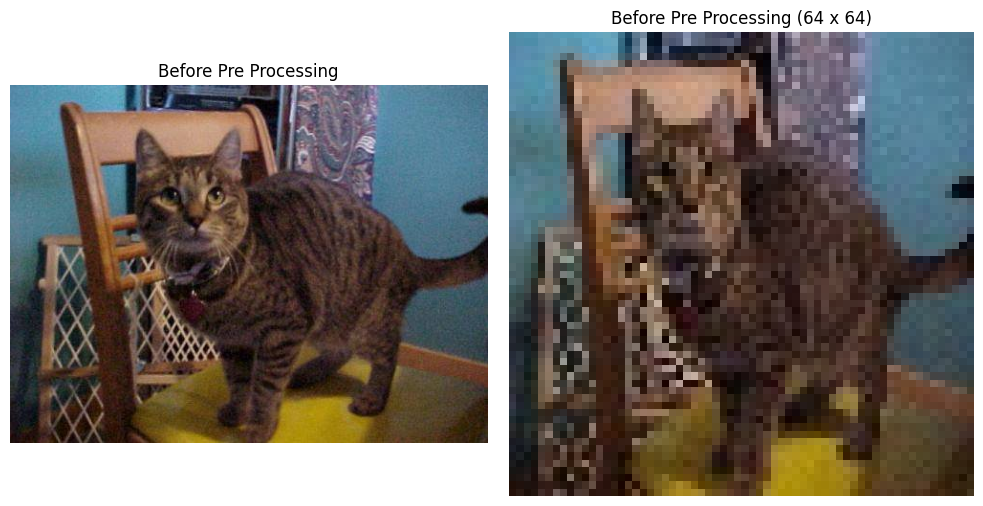

In [5]:
import matplotlib.pyplot as plt

img1_path = '/content/drive/MyDrive/animals/cats/cats_00001.jpg'
img2_path = '/content/drive/MyDrive/pre_processed_animals/cats/cats_00001.jpg'

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Before Pre Processing")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Before Pre Processing (64 x 64)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Spliting The Dataset

In [6]:
import numpy as np

In [7]:
base_dir = dst_base # defining base directory same as destination
num_folds = 5 # dividing in 5 folds
max_k = 30 # setting higgest k value

## Loading Preprocessed Image

In [8]:
data = []
labels = []

for label_index, category in enumerate(categories):
    path = os.path.join(base_dir, category)
    for img_name in tqdm(os.listdir(path), desc=f"Loading {category}"):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            data.append(img.flatten())
            labels.append(label_index)
        except Exception as e:
            continue

Loading panda: 100%|██████████| 100/100 [00:00<00:00, 110.81it/s]


## Converting Image to an Numpy Array

In [9]:
X = np.array(data)
y = np.array(labels)

## Dividing Images in 5 Fold

In [10]:
np.random.seed(100)
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
folds_X = np.array_split(X, num_folds)
folds_y = np.array_split(y, num_folds)
folds = list(zip(folds_X, folds_y))

# Training on The Dataset

## Applying KNN

In [11]:
# Knn Function
def knn_predict(test_sample, X_train, y_train, k):
    distances = np.sqrt(np.sum((X_train - test_sample) ** 2, axis=1)) # L2 Euclidean distances
    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest_indices]
    return np.bincount(nearest_labels).argmax()

## Measuring Accuracies of The Folds and Their Mean

In [12]:
average_accuracies = []  # Save all average accuracies of 5 folds
all_fold_accuracies = []  # Save all individual fold accuracies

for k in range(1, max_k + 1):
    fold_accuracies = []

    for i in range(num_folds):
        X_test, y_test = folds[i]
        X_train = np.vstack([folds[j][0] for j in range(num_folds) if j != i])
        y_train = np.hstack([folds[j][1] for j in range(num_folds) if j != i])

        predictions = [knn_predict(sample, X_train, y_train, k) for sample in X_test]
        acc = np.mean(np.array(predictions) == y_test)
        fold_accuracies.append(acc)

    avg_acc = np.mean(fold_accuracies)
    average_accuracies.append(avg_acc)
    all_fold_accuracies.append(fold_accuracies)


# Plotting The Result

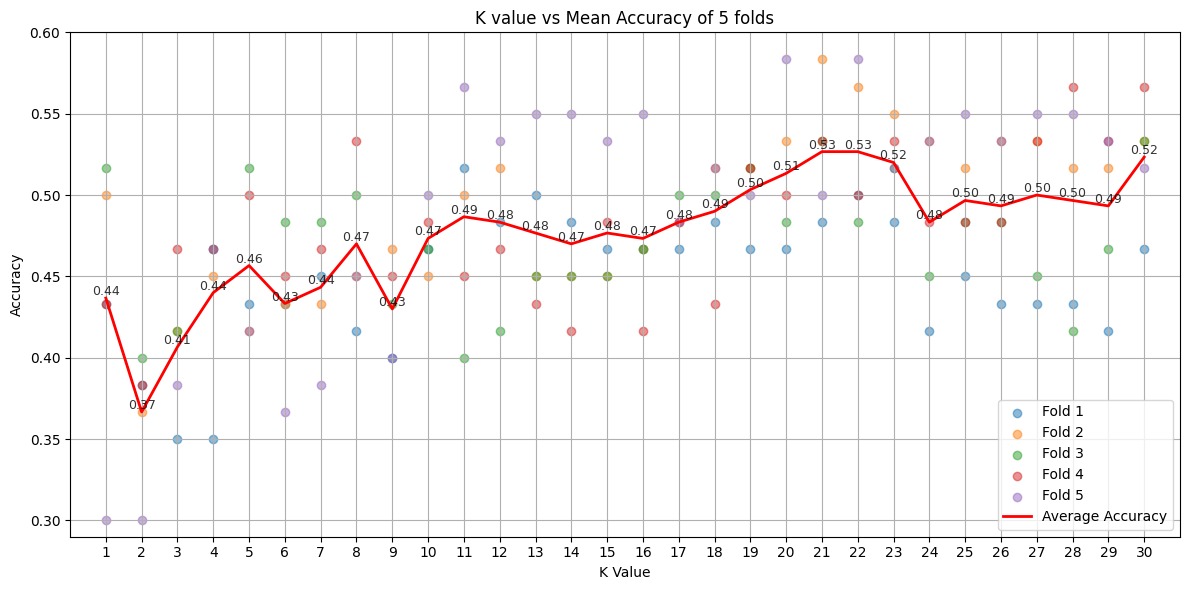

In [15]:
plt.figure(figsize=(12, 6))

k_values = range(1, max_k + 1)

# Plot all fold accuracies as scatter points
for fold_idx in range(num_folds):
    fold_k_accuracies = [all_fold_accuracies[k-1][fold_idx] for k in k_values]
    plt.scatter(k_values, fold_k_accuracies, label=f'Fold {fold_idx+1}', alpha=0.5)

plt.plot(k_values, average_accuracies, color='red', linewidth=2, label='Average Accuracy')
# Show the value of average accuracy points
for k, a in zip(k_values, average_accuracies):
    plt.text(k, a, f'{a:.2f}', fontsize=9, ha='center', va='bottom', alpha=0.8)

plt.title('K value vs Mean Accuracy of 5 folds')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.grid(True,)
plt.xticks(range(1, max_k + 1, 1))
plt.xlim(0, 31)
plt.ylim(0.29,0.60)
plt.legend()
plt.tight_layout()
plt.show()
